# Bike Sharing Prediction

![title](images/bikes.png)

## 1. Context and objective


This notebook is our final project for the class [MAP546P - Python for Data Science](https://moodle.polytechnique.fr/course/view.php?id=6124).

The objective is to **forecast the use of the city bikeshare system** in Washington. It is part of a [Kaggle competition](https://www.kaggle.com/c/bike-sharing-demand#description).

In [1]:
# Importing libraries
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sn

# Importing datasets
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

# Merging datasets
train["is_train"] = [1 for x in range(train.shape[0])]
test["is_train"] = [0 for x in range(test.shape[0])]
datasets = pd.concat([train, test], sort=False)
datasets = datasets.reset_index(drop = True)

## 2. Exploring the datasets (EDA)
### A. Structure of the datasets

In [2]:
train.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,is_train
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.0
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132,1.0
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454,0.0
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000,1.0
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000,1.0
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000,1.0
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000,1.0
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000,1.0


The **training** dataset has **~11k rows**, and **12 columns**:
- **<font color='grey'>datetime</font>** - hourly date + timestamp (from 2011-01-01 to 2012-12-19)
- **<font color='grey'>season</font>**
    -  1 = spring
    - 2 = summer
    - 3 = fall
    - 4 = winter 
- **<font color='grey'>holiday</font>** - whether the day is considered a holiday
- **<font color='grey'>workingday</font>** - whether the day is neither a weekend nor holiday
- **<font color='grey'>weather</font>** 
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy 
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist 
    - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds 
    - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
- **<font color='grey'>temp</font>** - temperature in Celsius (from 0.82 to 40)
- **<font color='grey'>atemp</font>** - "feels like" temperature in Celsius (from 0.76 to 45.45)
- **<font color='grey'>humidity</font>** - relative humidity (from 0% to 100%)
- **<font color='grey'>windspeed</font>** - wind speed (from 0 to 57)
- **<font color='grey'>casual</font>** - number of non-registered user rentals initiated (from 0 to 367)
- **<font color='grey'>registered</font>** - number of registered user rentals initiated (from 0 to 886)
- **<font color='grey'>count</font>** - number of total rentals (from 1 to 977)

In [3]:
test.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,is_train
count,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.0
mean,2.493300,0.029108,0.685815,1.436778,20.620607,24.012865,64.125212,12.631157,0.0
std,1.091258,0.168123,0.464226,0.648390,8.059583,8.782741,19.293391,8.250151,0.0
min,1.000000,0.000000,0.000000,1.000000,0.820000,0.000000,16.000000,0.000000,0.0
25%,2.000000,0.000000,0.000000,1.000000,13.940000,16.665000,49.000000,7.001500,0.0
50%,3.000000,0.000000,1.000000,1.000000,21.320000,25.000000,65.000000,11.001400,0.0
75%,3.000000,0.000000,1.000000,2.000000,27.060000,31.060000,81.000000,16.997900,0.0
max,4.000000,1.000000,1.000000,4.000000,40.180000,50.000000,100.000000,55.998600,0.0


The **test** dataset has **~6k** rows, and **the same columns**.

In [4]:
pd.DataFrame(data=datasets.isna().sum(), columns=["Number of NAs"]).transpose()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,is_train
Number of NAs,0,0,0,0,0,0,0,0,0,6493,6493,6493,0


Neither the training nor the test dataset has **missing entries**.

### B. Adding new variables

In [5]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,is_train
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,1
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,1
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,1
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,1


We can create new variables from ```datetime```.

In [6]:
datasets["year"] = [int(datasets.datetime[x][0:4]) for x in range(datasets.shape[0])]
datasets["month"] = [int(datasets.datetime[x][5:7]) for x in range(datasets.shape[0])]
datasets["day"] = [int(datasets.datetime[x][8:10]) for x in range(datasets.shape[0])]
datasets["hour"] = [int(datasets.datetime[x][11:13]) for x in range(datasets.shape[0])]
datasets["weekday"] = [datetime.datetime.strptime(datasets.datetime[x][0:10], '%Y-%m-%d').weekday() for x in range(datasets.shape[0])]

In [7]:
train = datasets[datasets.is_train == 1].drop(columns="is_train")
test = datasets[datasets.is_train == 0].drop(columns="is_train")

<font color='red'>Should we add external data?
- The hours of the sunset / sunrise to distinguish night time from day time</font>

### C. Visualisation
#### Outliers analysis

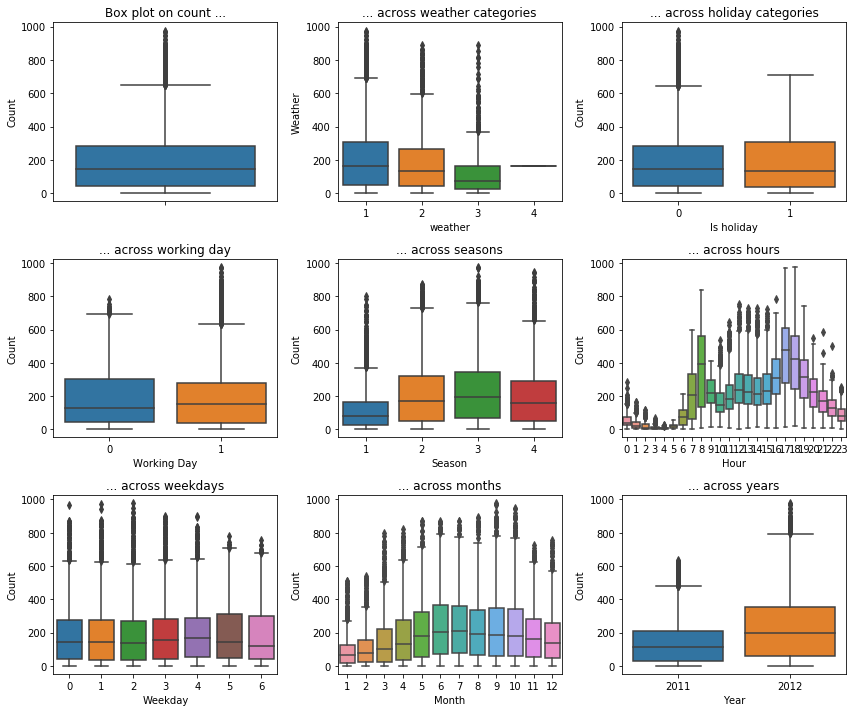

In [8]:
fig, axes = plt.subplots(nrows=3, ncols=3)
fig.set_size_inches(12, 10)


# Are there outliers?
sn.boxplot(data=train, y="count", orient="v", ax=axes[0][0])
axes[0][0].set(ylabel='Count', title="Box plot on count ...")


# Who are these outliers? 
sn.boxplot(data=train, y="count", x="weather", orient="v", ax=axes[0][1])
axes[0][1].set(ylabel='Weather', title="... across weather categories")

sn.boxplot(data=train, y="count", x="holiday", orient="v", ax=axes[0][2])
axes[0][2].set(xlabel='Is holiday', ylabel='Count', title="... across holiday categories")

sn.boxplot(data=train,  y="count", x="workingday" ,orient="v", ax=axes[1][0])
axes[1][0].set(xlabel='Working Day', ylabel='Count', title="... across working day")

sn.boxplot(data=train, y="count", x="season", orient="v",ax=axes[1][1])
axes[1][1].set(xlabel='Season', ylabel='Count', title="... across seasons")

sn.boxplot(data=train, y="count", x="hour", orient="v", ax=axes[1][2])
axes[1][2].set(xlabel='Hour', ylabel='Count', title="... across hours")

sn.boxplot(data=train, y="count", x="weekday", orient="v", ax=axes[2][0])
axes[2][0].set(xlabel='Weekday', ylabel='Count', title="... across weekdays")

sn.boxplot(data=train, y="count", x="month", orient="v", ax=axes[2][1])
axes[2][1].set(xlabel='Month', ylabel='Count', title="... across months")

sn.boxplot(data=train,y="count",x="year",orient="v",ax=axes[2][2])
axes[2][2].set(xlabel='Year', ylabel='Count',title="... across years")

plt.tight_layout()

**One can observe (high) outliers in the distribution of the ```count``` variable** (1st plot). They skew its distribution towards right.

The other plots help us investigating these outliers:
- They happen on the days when people work (that is, not during the week-ends nor the holidays)
- But not at the hours when they commute (that is, not from 6am to 9am nor from 4pm to 6pm) 

This indicates that these bikes are primarily used for work commute.

It is also interesting to notice that outliers are independent from the weather, the seasons or the months.

<br>
<br>
<font color='red'>**Remarques précédentes :**

The "count" variable contains outliers that skew the distribution towards right. We will try to investigate why it is so. --> could be linked to outliers of the "humidity" variable ? Few cases when 0 humidity --> high bike demand
General remarks to organize later:
- Few type 4 weather --> probably because it is 0 in this case (very bad weather) --> the average seems weird for this category
- Few spring data points
- Most of the outliers are from "Working Days".

Remplacer le graph température par le graph "heure", beaucoup plus intéressant.</font>

In [9]:
#Let's remove the outliers
trainWithoutOutliers = train[np.abs(train["count"]-train["count"].mean())<=(3*train["count"].std())] 
print("Number of outliers removed:", train.shape[0] - trainWithoutOutliers.shape[0])

Number of outliers removed: 147


/Users/ludmilaexbrayat/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


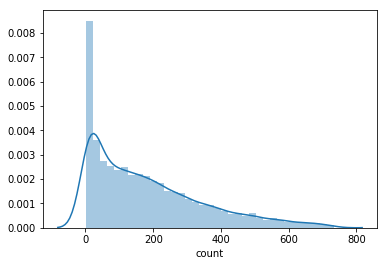

In [10]:
sn.distplot(trainWithoutOutliers['count'])
plt.show()

The distribution is indeed skewed, as seen in the outlier analysis (log scale in the model?)

#### Correlation analysis

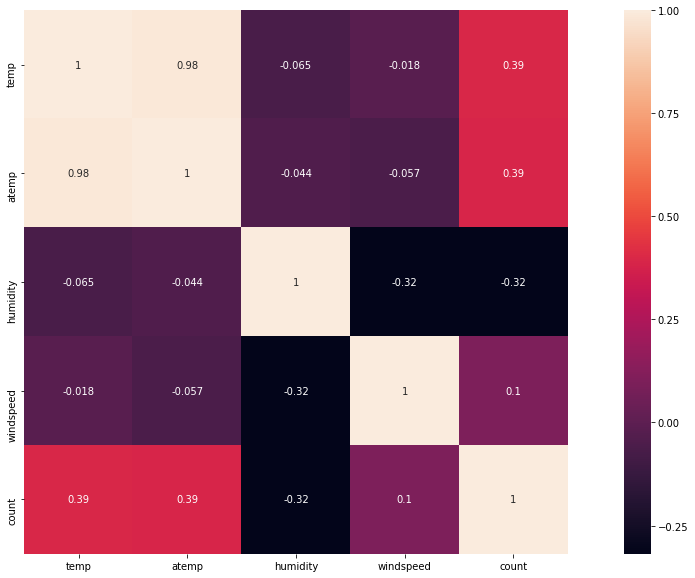

In [11]:
corr_matrix = train[["temp","atemp","humidity","windspeed","count"]].corr()
fig,ax= plt.subplots()
fig.set_size_inches(20,10)
sn.heatmap(corr_matrix, square=True,annot=True)

- temp and atemp too correlated --> we only keep one: atemp because we want to avoid multicollinearity in a regression
- windspeed seems to have a very low correlation with count
- humidity is negatively correlated with the count while temperature is positively correlated with the count (makes sense)

## Prediction